In [37]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN  # Importing DQN instead of A2C
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import logging

In [38]:
# Set up logging configuration
logging.basicConfig(filename='training_log.txt', level=logging.INFO, format='%(asctime)s - %(message)s')

# Define the environment for Cyber Defense (Reinforcement Learning)
class CyberDefenseEnv(gym.Env):
    def __init__(self, data):
        super(CyberDefenseEnv, self).__init__()
        # Define the action space and observation space here
        self.action_space = spaces.Discrete(3)  # Example: 3 actions
        self.feature_columns = [col for col in data.columns if col != 'Label']
        self.observation_space = spaces.Box(low=-1, high=1, shape=(len(self.feature_columns),), dtype=np.float32)
        self.data = data
        self.current_index = 0

In [39]:
# Check if GPU is available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the CSV files into pandas DataFrames
file_paths = [
    'K:/reinforcement learning project/dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    'K:/reinforcement learning project/dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'K:/reinforcement learning project/dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'K:/reinforcement learning project/dataset/Monday-WorkingHours.pcap_ISCX.csv',
    'K:/reinforcement learning project/dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'K:/reinforcement learning project/dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'K:/reinforcement learning project/dataset/Tuesday-WorkingHours.pcap_ISCX.csv',
    'K:/reinforcement learning project/dataset/Wednesday-workingHours.pcap_ISCX.csv'
]

# Load the CSV files into pandas DataFrames
dfs = [pd.read_csv(file_path) for file_path in file_paths]

# Concatenate all DataFrames into one
data = pd.concat(dfs, ignore_index=True)

# Sample 10% of the dataset for faster processing
data = data.sample(frac=0.1, random_state=42).reset_index(drop=True)

# Strip any leading or trailing whitespace from column names
data.columns = data.columns.str.strip()

# Convert the 'Label' column to numerical values using LabelEncoder
label_column = 'Label'  # Column name is now 'Label'

if label_column in data.columns:
    label_encoder = LabelEncoder()
    data[label_column] = label_encoder.fit_transform(data[label_column])
else:
    print(f"Target column '{label_column}' not found in the dataset. Please verify the correct column name.")

# Step 1: Replace Inf values with NaN, then handle NaN values
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Impute NaN values in numerical columns with the median
numerical_columns = data.select_dtypes(include=[np.number]).columns
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())

# Normalize the numerical columns using StandardScaler
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])


Using device: cuda


In [40]:
# Convert the 'Label' column to numerical values using LabelEncoder
label_column = 'Label'  # Column name is now 'Label'

if label_column in data.columns:
    label_encoder = LabelEncoder()
    data[label_column] = label_encoder.fit_transform(data[label_column])
else:
    print(f"Target column '{label_column}' not found in the dataset. Please verify the correct column name.")

# Step 1: Replace Inf values with NaN, then handle NaN values
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Impute NaN values in numerical columns with the median
numerical_columns = data.select_dtypes(include=[np.number]).columns
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())

# Step 3: Check if there are any remaining NaN or Inf values
assert not data.isnull().values.any(), "There are still NaN values in the data"
assert not np.isinf(data.values).any(), "There are still Inf values in the data"

# Step 4: Check for large values (optional) and clip if necessary
# Set a threshold value for extremely large values (for example, 1e5)
threshold = 1e5
data[numerical_columns] = data[numerical_columns].clip(-threshold, threshold)

# Step 5: Normalize the numerical columns using StandardScaler
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Step 6: Display the first few rows to verify the changes
print(data.head())



   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0          2.315129      -0.438611          -0.011692               -0.009595   
1         -0.439938      -0.437689          -0.010163               -0.008471   
2         -0.438464       2.535473           0.000537               -0.002851   
3         -0.439938      -0.437699          -0.007106               -0.008471   
4         -0.439938      -0.437162          -0.010163               -0.008471   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                    -0.090097                    -0.007228   
1                    -0.078839                    -0.007030   
2                    -0.037615                    -0.001190   
3                    -0.066919                    -0.007139   
4                    -0.075528                    -0.007142   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0              -0.290905              -0.307956            

In [41]:
# Load GPT-2 pre-trained model and tokenizer on CPU
gpt2_model = GPT2LMHeadModel.from_pretrained("distilgpt2").to(device)
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2", use_fast=True)

# Set the pad_token to the eos_token (as GPT-2 doesn't have a pad_token by default)
tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to eos_token if not already set


In [42]:
# Tokenizing input text and generating responses from GPT-2
def generate_feedback(logs):
    # Encode the input logs as input for GPT-2
    inputs = tokenizer.encode(logs, return_tensors="pt", truncation=True, padding=True, max_length=1024)
    
    # Move inputs to the correct device (CPU or GPU)
    inputs = inputs.to(device)

    # Create an attention mask: 1 for real tokens, 0 for padding tokens
    attention_mask = (inputs != tokenizer.pad_token_id).long()

    # Generate response based on the input logs
    outputs = gpt2_model.generate(inputs, max_length=1024, num_return_sequences=1, attention_mask=attention_mask, pad_token_id=tokenizer.eos_token_id)
    
    # Decode the generated response and return it as feedback
    feedback = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return feedback


In [49]:
# Set up logging configuration
logging.basicConfig(filename='training_log.txt', level=logging.INFO, format='%(asctime)s - %(message)s')

# Define the environment for Cyber Defense (Reinforcement Learning)
class CyberDefenseEnv(gym.Env):
    def __init__(self, data):
        super(CyberDefenseEnv, self).__init__()

        # Defining the action space (assuming 3 possible actions, e.g., 'Detect', 'Block', 'Investigate')
        self.action_space = spaces.Discrete(3)

        # The observation space, assuming the data contains numerical features
        self.feature_columns = [col for col in data.columns if col != 'Label']
        self.observation_space = spaces.Box(low=-1, high=1, shape=(len(self.feature_columns),), dtype=np.float32)

        # The data (i.e., the environment) and initial state
        self.data = data
        self.current_index = 0

    def reset(self, seed=None, **kwargs):
        state = self.data.iloc[self.current_index][self.feature_columns].values
        logging.info(f"Initial State: {state}")  # Logging the initial state at the start of each episode
        return state, {}

    def step(self, action):
        self.current_index += 1
        if self.current_index >= len(self.data):
            done = True
            self.current_index = 0
        else:
            done = False

        state = self.data.iloc[self.current_index][self.feature_columns].values
        attack_type = self.data.iloc[self.current_index]['Label']
        logs = f"Attack detected: {attack_type}. Current system state: {state}"
        feedback = generate_feedback(logs)

        # Adjusted reward function to ensure proper positive feedback
        reward = self.calculate_reward(feedback, action, attack_type)
        logging.info(f"Step: {self.current_index}, Action: {action}, Reward: {reward}, State: {state}")
        
        return state, reward, done, False, {}

    def calculate_reward(self, feedback, action, attack_type):
        # Improved reward function to provide positive rewards for good actions
        if 'neutralized' in feedback and action == 1:  # Block attack action
            return 10  # Positive reward for blocking the attack
        elif 'investigate' in feedback and action == 2:  # Investigate logs
            return 5  # Moderate reward for investigating
        elif 'detected' in feedback and action == 0:  # Detect attack
            return 3  # Reward for detecting the attack
        else:
            return -5  # Negative reward for failing to respond appropriately

# Define the environment (use a single environment for faster computation)
env = DummyVecEnv([lambda: CyberDefenseEnv(data)])

# Set up the DQN model with simplified configuration (smaller neural network)
model = DQN("MlpPolicy", env, verbose=1, learning_rate=0.001, device="cuda", buffer_size=5000, policy_kwargs=dict(net_arch=[64]))

# Train the model for 500 timesteps (faster training)
model.learn(total_timesteps=500)  # Reduced timesteps for faster training

# Save the model after training
model.save("trained_rl_cyber_defense_500_timesteps")


Using cuda device


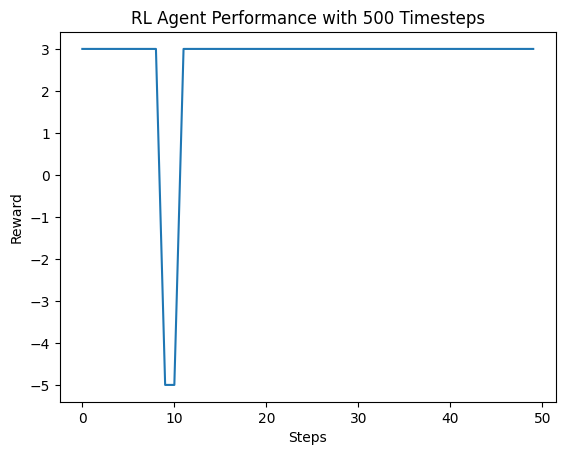

In [52]:
# Running and monitoring agent performance during training
rewards = []  # List to store rewards for plotting
state = env.reset()  # Initialize environment and get the initial state

# Increase exploration by adjusting epsilon decay to encourage more exploration initially
epsilon = 1.0  # Starting epsilon for exploration
epsilon_min = 0.1  # Minimum epsilon value (decay limit)
epsilon_decay = 0.995  # Decay rate for exploration

for step in range(50):  # Running for 50 steps or episodes
    action, _states = model.predict(state)  # Predict action from the model
    state, reward, done, info = env.step(action)  # Execute the action in the environment
    
    rewards.append(reward)  # Store reward for plotting
    
    # Log each step during training
    logging.info(f"Step {step} - Action: {action}, Reward: {reward}, State: {state}")
    
    # Decay epsilon (exploration rate) after each step
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    if done.any():  # If any environment is done, break the loop
        break

# After training, you can analyze the log in 'training_log.txt'

# Plotting the rewards during training
plt.plot(rewards)  # Plot the rewards over the steps
plt.title("RL Agent Performance with 500 Timesteps")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()  # Display the plot